<a href="https://colab.research.google.com/github/IAT-ExploringAI-2024/Computer-Vision-Project/blob/main/ComputerVisionProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<center><h1> <b> Object Detection Using YOLO <b> </h1></center>


This tutorial is designed to provide a comprehensive understanding of how to use YOLO, a state-of-the-art method in computer vision, for detecting objects in images.

Object detection and classification is a key technology in many areas, such as automated vehicles, security, and even healthcare.

We will begin with the basics of preparing (pre processing) an image dataset, ensuring it is ready for effective model training.We will then explore how YOLO, a type of convolutional neural network, automatically extracts features from images to recognize different objects. Understanding this process is crucial for grasping how YOLO operates.

The core of this tutorial is focused on transfer learning using YOLO. We will teach you how to take a pre-trained YOLO model and adapt it to a new dataset. This technique is efficient and powerful, allowing us to harness the strengths of YOLO with less computational effort.

By the end of this tutorial, you will have hands-on experience with preparing data, implementing YOLO, and understanding the principles behind it. This tutorial aims to equip students with practical skills and knowledge in one of the most exciting fields in technology.


Since its inception, the YOLO family of object detection models has come a long way. YOLOv8 is the most recent addition to this famous anchor-based single-shot family of object detectors. It comes with a bunch of improvements which include state-of-the-art accuracy and speed. In this article, we will be fine tuning the YOLOv8 object detection model on a real-world pothole detection dataset.


In the previous lecture, you were asked to make your own custom datasets for a project you want to work on. Today we will explore how to finetune YOLO on a certain dataset.


Importing required Libraries


In [3]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil

/Users/tigersu/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Dataset Description


Fruit Images for Object Detection

available on kaggle => https://www.kaggle.com/datasets/mbkinaci/fruit-images-for-object-detection

- 240 images in train folder. 60 images in test folder.

- 3 different fruits:

  - Apple

  - Banana

  - Orange

The labels are in xml format, which is Extensible markup language.Storing image dataset labels in XML format is quite common. XML provides a clear, hierarchical structure which is ideal for representing the complex data associated with image labels. This includes not just the class of the object, but potentially a wealth of other information like bounding box coordinates, object IDs, and additional metadata.


# Data Preprocessing

For preprocessing:

- We have to convert the dataset into that acceptable by YOLO.
  - Heirarchy of folders should be the one accepted by YOLO
  - Labels format should be darknet YOLO.
  - Labels files should be .txt files
- Check and see if there are any missing labels or images. And remove them from dataset.


## Heirarchy of Folders correction


Defining paths to train and test folders.


In [4]:
test_dir = "./OD_Vehicle_Types_VOC/test"
train_dir = "./OD_Vehicle_Types_VOC/train"
# '/content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/train_zip/train'

The train and test folders have all the images and labels together.

But for YOLO, the directories should be in:

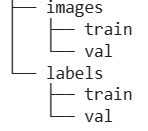


Making directories according to above struture of folders


In [5]:
import os

# run it once for making directories
if not os.path.exists("./OD_Vehicle_Types_VOC/Final_data"):
    os.makedirs("./OD_Vehicle_Types_VOC/Final_data")
    os.makedirs("./OD_Vehicle_Types_VOC/Final_data/images")
    os.makedirs("./OD_Vehicle_Types_VOC/Final_data/labels")
    os.makedirs("./OD_Vehicle_Types_VOC/Final_data/images/train")
    os.makedirs("./OD_Vehicle_Types_VOC/Final_data/images/val")
    os.makedirs("./OD_Vehicle_Types_VOC/Final_data/labels/train")
    os.makedirs("./OD_Vehicle_Types_VOC/Final_data/labels/val")

In [6]:
# set the paths to labels and images directory
label_dir = "./OD_Vehicle_Types_VOC/Final_data/labels"
image_dir = "./OD_Vehicle_Types_VOC/Final_data/images"

Copy XML files and jpg files from the train folder to the folders created.


In [7]:
# import shutil
# run it once for copying!
for file in os.listdir(train_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(train_dir, file), os.path.join(label_dir, "train"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(train_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir, "train", new_filename), "JPEG")
        # shutil.copy(os.path.join(train_dir, file), os.path.join(image_dir, "train"))


# Copy XML files and jpg files from the test folder to the folders created.
for file in os.listdir(test_dir):
    if file.endswith(".xml"):
        shutil.copy(os.path.join(test_dir, file), os.path.join(label_dir, "val"))
    if file.endswith(".jpg"):
        image = Image.open(os.path.join(test_dir, file))
        image = image.convert("RGB")
        new_filename = os.path.splitext(file)[0] + ".jpg"
        image.save(os.path.join(image_dir, "val", new_filename), "JPEG")
        # shutil.copy(os.path.join(test_dir, file), os.path.join(image_dir, "val"))

Visualizing somme pictures from the dataset


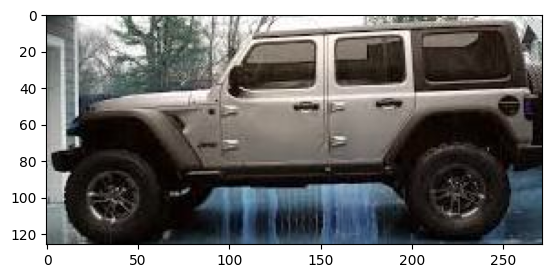

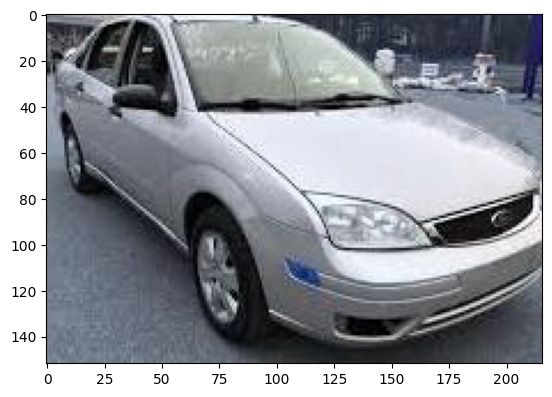

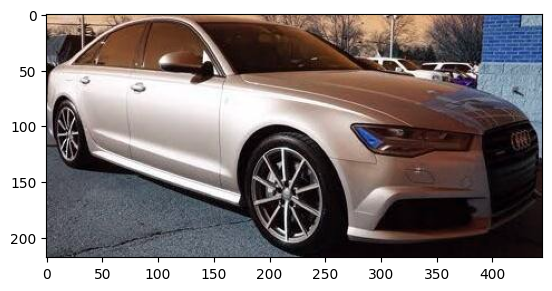

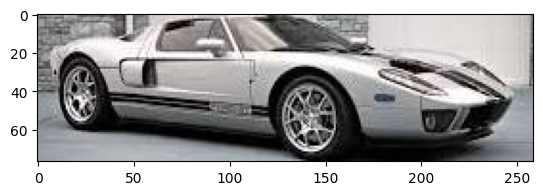

In [8]:
# visualize first four sample images from train data
for idx, image in enumerate(os.listdir(os.path.join(image_dir, "train"))):
    img = cv2.imread(os.path.join(image_dir, "train", image), 1)
    plt.imshow(img)
    plt.show()

    if idx == 3:
        break

## Creating Text files for labels

Creating Dataframes from .xml files, from which we will eventually create .txt file for each image


In [9]:
# import glob
# import xml.etree.ElementTree as ET

df = {
    "name": [],
    "label": [],
    "width": [],
    "height": [],
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
}


# This is the way to handle xml format files which are in heirarchial form (trees).

for idx, anno in enumerate(glob.glob(label_dir + "/train" + "/*.xml")):

    trees = ET.parse(anno)

    print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        print(item)

        if item.tag == "size":
            for attr in list(item):
                if attr.tag == "width":
                    width = int(round(float(attr.text)))
                if attr.tag == "height":
                    height = int(round(float(attr.text)))

        if item.tag == "object":
            for attr in list(item):
                if "name" in attr.tag:
                    label = attr.text
                    df["label"] += [label]
                    df["width"] += [width]
                    df["height"] += [height]
                    df["name"] += [anno.split("/")[-1][0:-4]]

                if "bndbox" in attr.tag:
                    for dim in attr:
                        if dim.tag == "xmin":
                            xmin = int(round(float(dim.text)))
                            df["xmin"] += [xmin]

                        if dim.tag == "ymin":
                            ymin = int(round(float(dim.text)))
                            df["ymin"] += [ymin]
                        if dim.tag == "xmax":
                            xmax = int(round(float(dim.text)))
                            df["xmax"] += [xmax]
                        if dim.tag == "ymax":
                            ymax = int(round(float(dim.text)))
                            df["ymax"] += [ymax]

./OD_Vehicle_Types_VOC/Final_data/labels/train/49bd31b4c8_jpg.rf.dc33cf527a35a2b987bbcbb42b61f3a0.xml
<Element 'annotation' at 0x29a19e590>
<Element 'folder' at 0x29a19e4f0>
<Element 'filename' at 0x29a19e6d0>
<Element 'path' at 0x29a19e4a0>
<Element 'source' at 0x29a19e900>
<Element 'database' at 0x29a19e040>
<Element 'size' at 0x29a19e130>
<Element 'width' at 0x29a19ef90>
<Element 'height' at 0x29a19e2c0>
<Element 'depth' at 0x29a19e400>
<Element 'segmented' at 0x29a19e5e0>
<Element 'object' at 0x29a19e450>
<Element 'name' at 0x29a19e3b0>
<Element 'pose' at 0x29a19e630>
<Element 'truncated' at 0x29a19ee50>
<Element 'difficult' at 0x29a1a3180>
<Element 'occluded' at 0x29a1a31d0>
<Element 'bndbox' at 0x29a1a35e0>
<Element 'xmin' at 0x29a1a3630>
<Element 'xmax' at 0x29a1a34a0>
<Element 'ymin' at 0x29a1a3130>
<Element 'ymax' at 0x29a1a3400>
<Element 'polygon' at 0x29a1a3270>
<Element 'x1' at 0x29a1a33b0>
<Element 'y1' at 0x29a1a32c0>
<Element 'x2' at 0x29a1a3310>
<Element 'y2' at 0x29a1a

Doing the same for validation data labels.


In [10]:
# import glob
# import xml.etree.ElementTree as ET

df2 = {
    "name": [],
    "label": [],
    "width": [],
    "height": [],
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
}


# This is the way to handle xml format files which are in heirarchial form (tees).

for idx, anno in enumerate(glob.glob(label_dir + "/val" + "/*.xml")):

    trees = ET.parse(anno)

    # print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        # print(item)

        if item.tag == "size":
            for attr in list(item):
                if attr.tag == "width":
                    width = int(round(float(attr.text)))
                if attr.tag == "height":
                    height = int(round(float(attr.text)))

        if item.tag == "object":
            for attr in list(item):
                if "name" in attr.tag:
                    label = attr.text
                    df2["label"] += [label]
                    df2["width"] += [width]
                    df2["height"] += [height]
                    # dataset['name']+=[anno.split('/')[-1][0:-4]]
                    df2["name"] += [anno.split("/")[-1][0:-4]]

                if "bndbox" in attr.tag:
                    for dim in attr:
                        if dim.tag == "xmin":
                            xmin = int(round(float(dim.text)))
                            df2["xmin"] += [xmin]

                        if dim.tag == "ymin":
                            ymin = int(round(float(dim.text)))
                            df2["ymin"] += [ymin]
                        if dim.tag == "xmax":
                            xmax = int(round(float(dim.text)))
                            df2["xmax"] += [xmax]
                        if dim.tag == "ymax":
                            ymax = int(round(float(dim.text)))
                            df2["ymax"] += [ymax]

In [11]:
import pandas as pd

train_df = pd.DataFrame(df)
val_df = pd.DataFrame(df2)
# df1.head()
val_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax
0,878c29032b_jpg.rf.698327df230e269f6290b9993f68...,SUV,532,253,8,3,533,251
1,bf60c339f2_jpg.rf.f335e3ce279334fa27a57bcad8b8...,Cars,227,113,5,5,224,111
2,04932e6971_jpg.rf.a5699bff5abb01e46587e3aaf6a3...,Cars,238,104,1,4,235,104
3,d923bbc09b_jpg.rf.885e5efc6707bad322fb04ec609d...,Trucks,254,131,5,5,255,131
4,9784c8b879_jpg.rf.238e14fe333fe233ed963e705f00...,Cars,282,117,1,4,280,117


Visualizing one of the image in train set with the bounding box


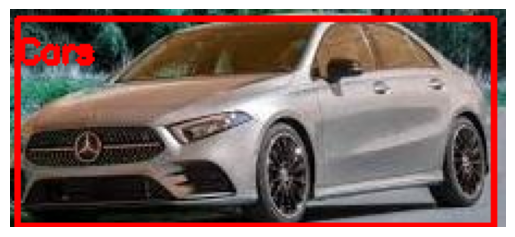

In [12]:
index = 10  # picture to visualize

# import cv2
image = cv2.imread(
    os.path.join(image_dir, "train", train_df["name"][index] + ".jpg"), 1
)
# Draw rectangle
cv2.rectangle(
    image,
    (train_df["xmin"][index], train_df["ymin"][index]),
    (train_df["xmax"][index], train_df["ymax"][index]),
    (255, 0, 0),
    2,
)
# Put label (class_id) near the bbox
label = train_df["label"][index]
cv2.putText(
    image,
    str(label),
    (train_df["xmin"][index], train_df["ymin"][index] + 20),
    cv2.FONT_HERSHEY_SIMPLEX,
    0.5,
    (255, 0, 0),
    2,
)
# Display image
plt.imshow(image)
plt.axis("off")
plt.show()

Checking to see if the above image has bounding boxes around other apples or not.


In [13]:
train_df["name"][index]
filtered_df = train_df[train_df["name"] == train_df["name"][index]]
print(filtered_df)

                                                 name label  width  height  \
10  d0e6018f26_jpg.rf.6486e449b0fd549e6fc6e62ff6bf...  Cars    228     100   

    xmin  ymin  xmax  ymax  
10     3     4   222    99  


Checking to see the datatypes of all the columns and if there is any null value that needs to be eliminated from the data.


In [14]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    38 non-null     object
 1   label   38 non-null     object
 2   width   38 non-null     int64 
 3   height  38 non-null     int64 
 4   xmin    38 non-null     int64 
 5   ymin    38 non-null     int64 
 6   xmax    38 non-null     int64 
 7   ymax    38 non-null     int64 
dtypes: int64(6), object(2)
memory usage: 2.5+ KB


What different types of labels are assigned to each sample and checking if they match the provided label/class information, i.e. there are no extra labels due to mistakes in spellings etc.


In [15]:
print(train_df["label"].unique())
print(val_df["label"].unique())

['Cars' 'SUV' 'Crossovers' 'Trucks' 'Minivan']
['SUV' 'Cars' 'Trucks' 'Crossovers' 'Minivan']


We need to map labels to class_ids required for YOLO


In [16]:
label_map = {"Cars": 0, "Crossovers": 1, "SUVs": 2, "Trucks": 3}

train_df["class"] = train_df["label"].map(label_map)
val_df["class"] = val_df["label"].map(label_map)

In [17]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class
0,49bd31b4c8_jpg.rf.dc33cf527a35a2b987bbcbb42b61...,Cars,445,218,1,4,442,217,0.0
1,4c1e13d54f_jpg.rf.862635b202563552cbda244b0596...,Cars,216,152,6,2,217,145,0.0
2,595cb8dbe4_jpg.rf.6883620815f1b4f93425aec9e1b5...,SUV,272,126,5,5,268,125,NaN
3,c2d18af036_jpg.rf.ed452d2d55f5a65f2daac6358574...,Cars,259,77,9,2,249,76,0.0
4,af381496ad_jpg.rf.eebf99e6dca29119a06576ca047e...,Cars,240,71,9,3,241,72,0.0


convertig the bounding box format to the one required by YOLO:


In [18]:
# Training data
train_df["x_center"] = (train_df["xmin"] + train_df["xmax"]) / (2 * train_df["width"])
train_df["y_center"] = (train_df["ymin"] + train_df["ymax"]) / (2 * train_df["height"])
train_df["box_width"] = (train_df["xmax"] - train_df["xmin"]) / train_df["width"]
train_df["box_height"] = (train_df["ymax"] - train_df["ymin"]) / train_df["height"]

# Validation data
val_df["x_center"] = (val_df["xmin"] + val_df["xmax"]) / (2 * val_df["width"])
val_df["y_center"] = (val_df["ymin"] + val_df["ymax"]) / (2 * val_df["height"])
val_df["box_width"] = (val_df["xmax"] - val_df["xmin"]) / val_df["width"]
val_df["box_height"] = (val_df["ymax"] - val_df["ymin"]) / val_df["height"]

In [19]:
train_df.head()

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
0,49bd31b4c8_jpg.rf.dc33cf527a35a2b987bbcbb42b61...,Cars,445,218,1,4,442,217,0.0,0.497753,0.506881,0.991011,0.977064
1,4c1e13d54f_jpg.rf.862635b202563552cbda244b0596...,Cars,216,152,6,2,217,145,0.0,0.516204,0.483553,0.976852,0.940789
2,595cb8dbe4_jpg.rf.6883620815f1b4f93425aec9e1b5...,SUV,272,126,5,5,268,125,NaN,0.501838,0.515873,0.966912,0.952381
3,c2d18af036_jpg.rf.ed452d2d55f5a65f2daac6358574...,Cars,259,77,9,2,249,76,0.0,0.498069,0.506494,0.926641,0.961039
4,af381496ad_jpg.rf.eebf99e6dca29119a06576ca047e...,Cars,240,71,9,3,241,72,0.0,0.520833,0.528169,0.966667,0.971831


Deleting all the sample with Nan values in training and validation data


In [20]:
# training
print("before deleting (train data): ", train_df.shape)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
train_df.dropna(inplace=True)
print("after deleting(train_data): ", train_df.shape)

# validation
print("before deleting (val data): ", val_df.shape)
val_df.replace([np.inf, -np.inf], np.nan, inplace=True)
val_df.dropna(inplace=True)
print("after deleting(val data): ", val_df.shape)

before deleting (train data):  (267, 13)
after deleting(train_data):  (184, 13)
before deleting (val data):  (38, 13)
after deleting(val data):  (27, 13)


converting the dataframe to type _str_ (string) to be stored in text files.


In [21]:
train_df = train_df.astype(str)
val_df = val_df.astype(str)

If there are more than one bounding boxes in single image, they should be written in one text file. As, you can see in the below example that one image has so many bounding boxes.


In [22]:
filtered_df = train_df[train_df["name"] == train_df["name"][100]]
(filtered_df.head(15))

,name,label,width,height,xmin,ymin,xmax,ymax,class,x_center,y_center,box_width,box_height
100,85910d7390_jpg.rf.cda1bffd06a474be091b3823a6e3...,Cars,1017,542,5,11,1004,537,0.0,0.4960668633235005,0.5055350553505535,0.9823008849557522,0.9704797047970479


In [23]:
# file_name = [x.split('.')[0] for x in df1["name"]]

# TRAINING DATA
# finding all the unique names:
unique_names = train_df["name"].unique()

# for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
    data = train_df[train_df.name == name]
    box_list = []
    for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(
            row["class"]
            + " "
            + row["x_center"]
            + " "
            + row["y_center"]
            + " "
            + row["box_width"]
            + " "
            + row["box_height"]
        )

    # writing on text files
    text = "\n".join(box_list)
    with open(f"{label_dir}/train/{name}.txt", "w") as file:
        file.write(text)
#############################################################################################
# VALIDATION DATA
# finding all the unique names:
unique_names = val_df["name"].unique()

# for each unique name, containing multiple bboxes, combine them together.
for name in unique_names:
    data = val_df[val_df.name == name]
    box_list = []
    for idx in range(len(data)):
        row = data.iloc[idx]
        box_list.append(
            row["class"]
            + " "
            + row["x_center"]
            + " "
            + row["y_center"]
            + " "
            + row["box_width"]
            + " "
            + row["box_height"]
        )

    # writing on text files
    text = "\n".join(box_list)
    with open(f"{label_dir}/val/{name}.txt", "w") as file:
        file.write(text)

## Checking Missing Files

Checking the folders if every image file has a corresponding label file

(We will copy the code, we already used in previous turorial after updating)


In [24]:
# The lists of all the images and labels for train and validation set:
train_images = glob.glob(os.path.join(image_dir, "train", "*.jpg"))
train_labels = glob.glob(os.path.join(label_dir, "train", "*.txt"))
val_images = glob.glob(os.path.join(image_dir, "val", "*.jpg"))
val_labels = glob.glob(os.path.join(label_dir, "val", "*.txt"))
# print(val_labels)

# Get the list of filenames without extensions
image_files_train = {file.split("/")[-1].split(".")[0] for file in train_images}
label_files_train = {file.split("/")[-1].split(".")[0] for file in train_labels}

image_files_val = {file.split("/")[-1].split(".")[0] for file in val_images}
label_files_val = {file.split("/")[-1].split(".")[0] for file in val_labels}
# print(image_files_val)

In [25]:
print(len(image_files_val), "  =  ", len(label_files_val))

37   =   27


In [26]:
# Find extra files in each folder

# TRAINING DATA
extra_images_train = image_files_train - label_files_train
extra_labels_train = label_files_train - image_files_train

# Output the results
print(f"Training Extra images (without corresponding labels): {extra_images_train}")
print(f"Training Extra labels (without corresponding images): {extra_labels_train}")


# VALIDATION DATA
extra_images_val = image_files_val - label_files_val
extra_labels_val = label_files_val - image_files_val

# Output the results
print(f"Validation Extra images (without corresponding labels): {extra_images_val}")
print(f"Validation Extra labels (without corresponding images): {extra_labels_val}")

Training Extra images (without corresponding labels): {'2019_Chrysler_Pacifica_Touring_L-_front_7-4-19_jpg', 'bbeb8be1a5_jpg', 'd9ac4e3d35_jpg', 'b2683449e4_jpg', '8ba45e63f5_jpg', '96d36929e9_jpg', '3fc896d802_jpg', '7cb6de55ca_jpg', '69a4d91c32_jpg', '35e76b598c_jpg', 'aa2e476814_jpg', 'Used_Minivans_2019_Honda_Odyssey_Elite_png', '9590491ece_jpg', 'CC24_RUCL53_2DE_PW7_APA_XXX_XXX_XXX-e4332206caf8cc1db1e8a5296d38b2c1_png', '96efaf7131_jpg', 'dc3ed5826d_jpg', 'f7f74e7fed_jpg', '6de9431b59_jpg', 'bcc7ba131e_jpg', '413e016541_jpg', '67ae5b5db5_jpg', '65316e9cb9_jpg', '65e3914b75_jpg', '4527eab2b2_jpg', 'd8cb96e640_jpg', '7124cd0b8e_jpg', 'e069a063b6_jpg', '9018b5ec32_jpg', '70aa0d8bda_jpg', '488149-chrysler-grand-caravan-2021-la-fin-d-un-regne_jpeg', '363c356356_jpg', '91bca35541_jpg', '32e868a0f0_jpg', '60baae6a9e_jpg', 'af7438b2d9_jpg', 'adb725751f_jpg', 'b9ae5004fd_jpg', '429bd2e3ae_jpg', 'b364b49838_jpg', 'bfcade8098_jpg', 'a3df6ce99d_jpg', '6611881e5c_jpg', '707497cca0_jpg', 'b24_g

Make sure that the above info is correct by chceking the data manually.


Now removing from the dataset:


In [27]:
for file in extra_images_train:
    file_path = os.path.join(image_dir, "train", file + ".jpg")
    if os.path.exists(file_path):
        os.remove(file_path)  # or '.png' depending on your image format

for file in extra_images_val:
    file_path = os.path.join(image_dir, "val", file + ".jpg")
    if os.path.exists(file_path):
        os.remove(file_path)

Now run the above cells again to find if all the missing data is deleted.


# Custom object detection using YOLO


First install and import


In [28]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.25 🚀 Python-3.9.6 torch-2.2.1 CPU (Apple M1 Pro)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 126.3/460.4 GB disk)


In [29]:
from ultralytics import YOLO

## Training YOLO


We are going to select small pretrained (on COCO dataset) model of YOLOv8


In [30]:
model = YOLO("yolov8s.pt")  # pretrained model

The detailed architecture of the model can be seen from:


In [31]:
model

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s

In [39]:
%%writefile config.yaml
path: ./OD_Vehicle_Types_VOC/Final_data
train: ./OD_Vehicle_Types_VOC/Final_data/images/train
#test: (test dataset folder path)
val: ./OD_Vehicle_Types_VOC/Final_data/images/val

# Classes
nc: 4 # replace based on your dataset's number of classes

# Class names
# replace all class names with your own classes' names
names:
  0: Cars
  1: Crossovers
  2: SUVs
  3: Trucks

Overwriting config.yaml


Please look at [Yolo train Docs](https://docs.ultralytics.com/modes/train/#train-settings) for hyperparameters for model tuning and configuration, e.g. lr0, imgsz, model etc.


In [41]:
model.train(data="config.yaml", epochs=5, patience=5, batch=8, lr0=0.0005, imgsz=640)

Ultralytics YOLOv8.1.25 🚀 Python-3.9.6 torch-2.2.1 CPU (Apple M1 Pro)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=config.yaml, epochs=5, time=None, patience=5, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train14, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, forma

RuntimeError: Dataset 'config.yaml' error ❌ 
Dataset 'config.yaml' images not found ⚠️, missing path '/Users/tigersu/Desktop/Study/SFU/Spring2024/IAT885/Labs/CV/OD_Vehicle_Types_VOC/Final_data/OD_Vehicle_Types_VOC/Final_data/images/val'
Note dataset download directory is '/Users/tigersu/Desktop/Study/SFU/Spring2024/IAT885/Labs/CV'. You can update this in '/Users/tigersu/Library/Application Support/Ultralytics/settings.yaml'

## Evaluation Metrics


[This](https://docs.ultralytics.com/guides/yolo-performance-metrics/) is a very good detailed explanation of different perfromance metrics in YOLO.


**Choosing the Right Metrics**

Choosing the right metrics to evaluate often depends on the specific application.

- mAP: Suitable for a broad assessment of model performance.

- IoU: Essential when precise object location is crucial.

- Precision: Important when minimizing false detections is a priority.

- Recall: Vital when it's important to detect every instance of an object.

- F1 Score: Useful when a balance between precision and recall is needed.


In [ ]:
metrics = model.val()  # no arguments needed, dataset and settings remembered
metrics.box.map  # map50-95
metrics.box.map50  # map50
metrics.box.map75  # map75
metrics.box.maps  # a list contains map50-95 of each category
metrics.box.mp  # P
metrics.box.mr  # R

Ultralytics YOLOv8.1.19 🚀 Python-3.10.12 torch-2.1.0+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /content/drive/MyDrive/Tutorials/Datasets/FRUIT DATA/Final_data/labels/val.cache... 56 images, 0 backgrounds, 0 corrupt: 100%|██████████| 56/56 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:38<00:00,  5.47s/it]


                   all         56        110      0.722       0.67      0.735      0.475
                orange         56         41      0.652       0.61      0.694      0.494
                 apple         56         33      0.832      0.788      0.837      0.584
                banana         56         36      0.682      0.611      0.674      0.348
Speed: 3.2ms preprocess, 640.6ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train4


0.6695819988502915

Showing confusion matrix, that is already stored in detect/train folder


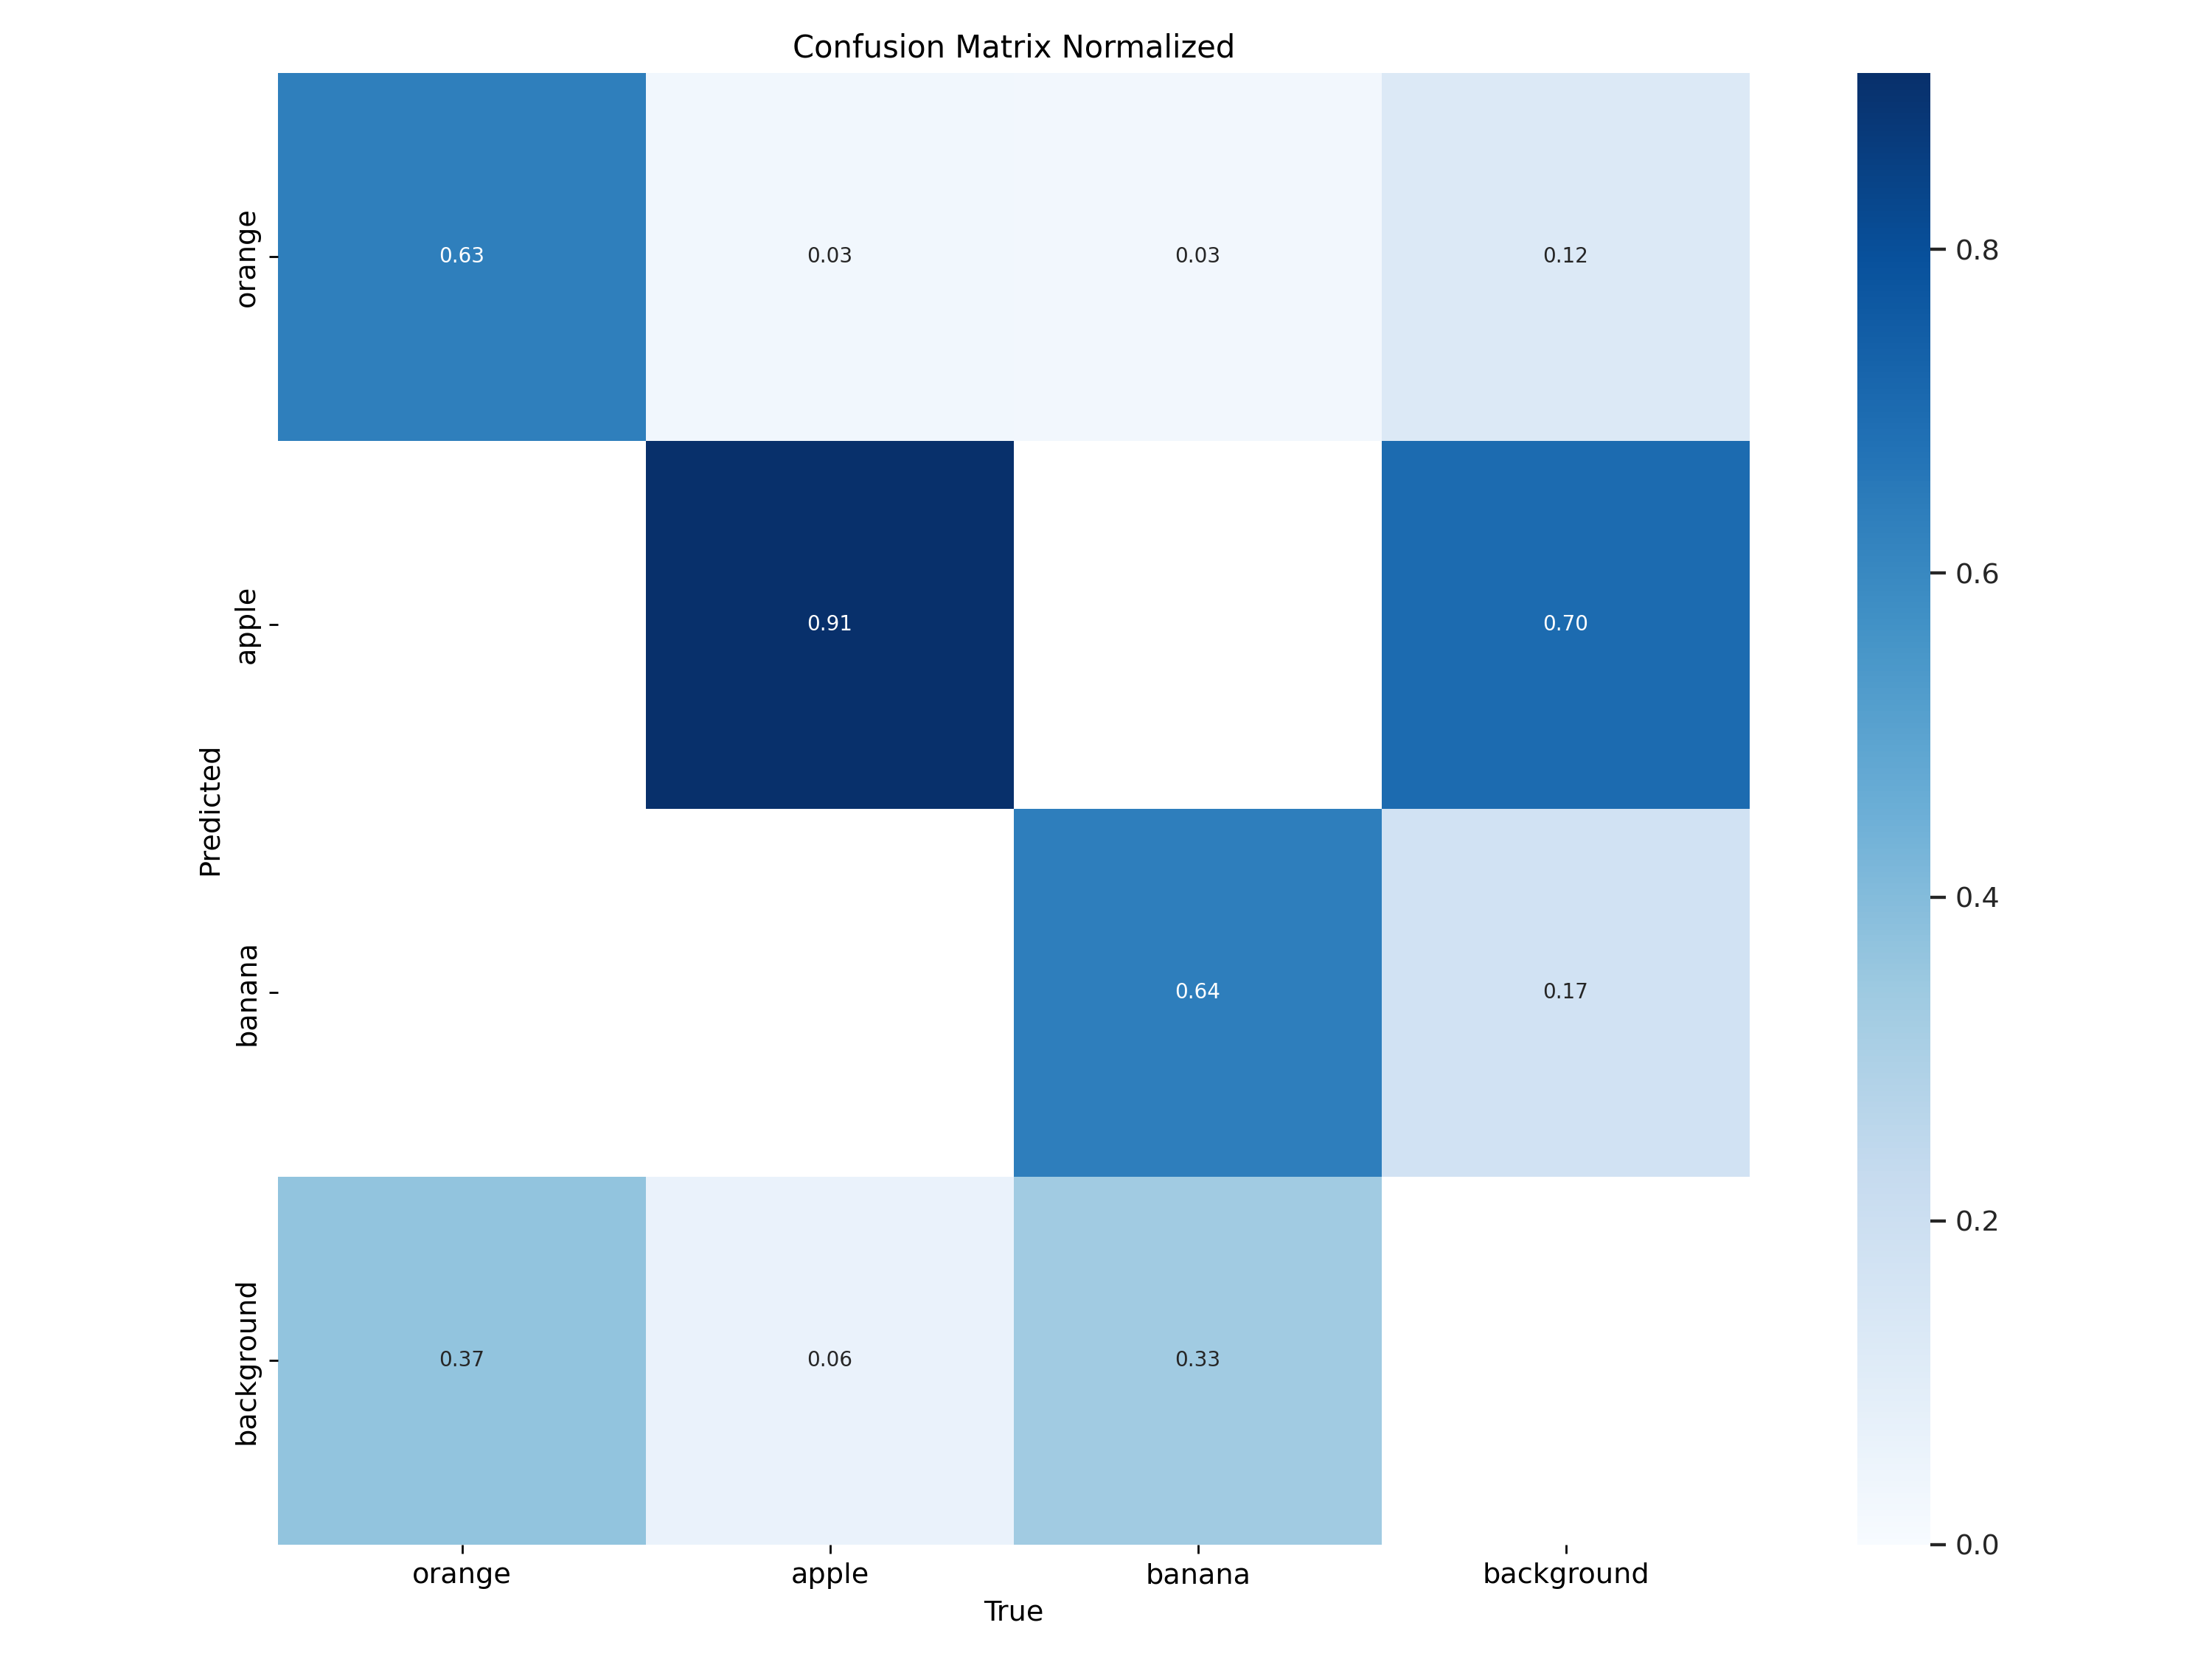

In [ ]:
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/train/confusion_matrix_normalized.png')

##Prediction


In [ ]:
model = YOLO(' )  # load a custom model

# Predict with the model with any image from internet?
results = model('https://www.freshpoint.com/wp-content/uploads/2019/08/freshpoint-produce-101-apples-bananas.jpg', save=True)

100%|██████████| 126k/126k [00:00<00:00, 580kB/s] 


image 1/1 /content/freshpoint-produce-101-apples-bananas.jpg: 576x640 2 apples, 3 bananas, 112.8ms
Speed: 1.8ms preprocess, 112.8ms inference, 1.7ms postprocess per image at shape (1, 3, 576, 640)
Results saved to runs/detect/predict


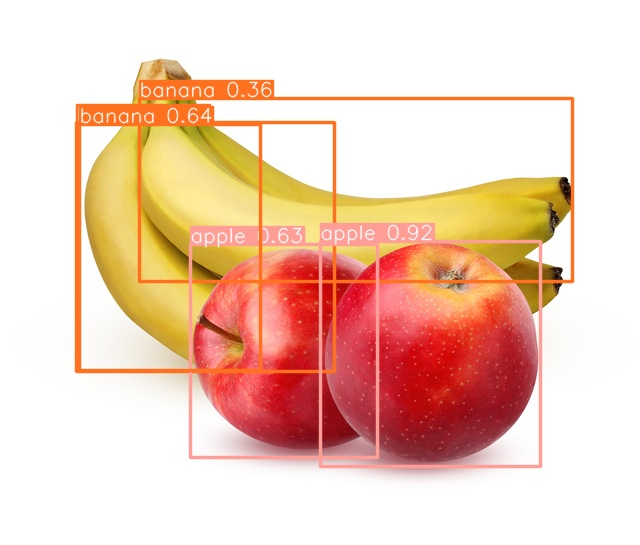

In [ ]:
# SHOW THE IMAGE STORED
%matplotlib inline
from PIL import Image

Image.open('/content/runs/detect/predict/freshpoint-produce-101-apples-bananas.jpg')